Putting the sequential feeding of data into the RNN part of the RNN module (how else are we going to be able to train our thalamus layer??). Implements strucutre of RNN then linear layer then RNN. DOES NOT RUN BUT I AM TIRED AND AM GIVING UP

In [ ]:
from scipy.io import loadmat
import numpy as np
import torch 


In [ ]:
monkey_data = loadmat('monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]


In [ ]:
test = np.zeros((502, 2))
for i, data in enumerate(visual_data):
    test[i] = data.shape

print(test[:,1].max())

In [ ]:
batch_size = visual_data.shape[0] # N, 502
trial_len = int(test[:,1].max()) # visual_data[0].shape[1] # T, 298 
in_dim = visual_data[0].shape[0] # L, 21
out_dim = muscle_data[0].shape[0] # O, 50

hid_dim = 100
num_layers = 3

In [ ]:
new_visual_data = np.zeros((batch_size, trial_len, in_dim))

for i, data in enumerate(visual_data):
    new_visual_data[i, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
print(new_visual_data.shape)

In [86]:
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
# np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

train_input = np.zeros((int(batch_size * .8), trial_len, in_dim))
train_output = np.zeros((int(batch_size * .8), trial_len, out_dim))
test_input = np.zeros((int(np.ceil(batch_size * .2)), trial_len, in_dim))
test_output = np.zeros((int(np.ceil(batch_size * .2)), trial_len, out_dim))
train_ind = 0
test_ind = 0
for i, data in enumerate(visual_data):
     if i in train_idx:
       # train_input[train_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
       train_input[train_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
       train_output[train_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
       train_ind += 1
     else:
        test_input[test_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
        test_output[test_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
        test_ind += 1





- ReTanh activation function --> yes
- rate regularization: 1e-1 --> yes
- weight regularization: 1e-5 --> yes
- intermodule sparsity: 0.1 --> no
- Hessian free optimization --> yes
- birdirectional --> no

In [87]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)
    loss = torch.mean((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [100]:
from torch import nn

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False


model = MilliesRNN(in_dim, hid_dim, out_dim)
criterion = nn.MSELoss() 
# criterion = hardcore_loss
if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))


for epoch in range(num_epochs):
    batches = []
    shuffed = np.arange(0,401)
    np.random.shuffle(shuffed)
    for i in range(5): # minibatching w/ replacement   
        idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
        
        batches.append(train_input[idx])
    
    for j, batch in enumerate(batches):
        
        optimizer.zero_grad()

        outputs = model(torch.from_numpy(train_input[batch]).to(torch.float32))    

        loss = criterion(outputs, torch.from_numpy(train_output[batch]).to(torch.float32))
        # loss = criterion(outputs, torch.from_numpy(train_output).to(torch.float32), model.named_parameters())
            
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output = model(torch.from_numpy(train_input[batch]).to(torch.float32))
            loss = criterion(gen_output, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        loss_error.append(loss.item())
        # if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{j + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )
        



IndexError: arrays used as indices must be of integer (or boolean) type

Text(0, 0.5, 'mse loss')

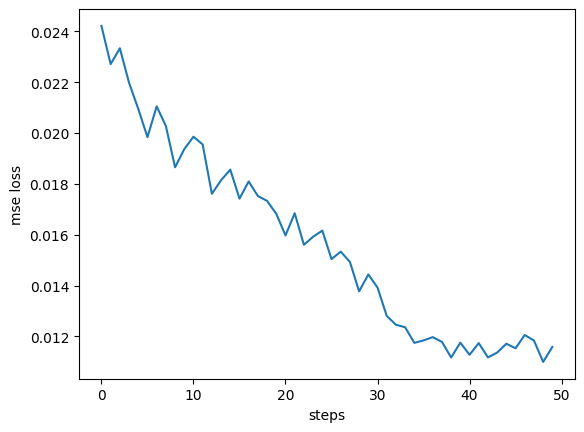

In [95]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("mse loss")

In [ ]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

In [ ]:
preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
num_samples = len(test_dataset)

model.eval()


total_loss = 0
with torch.no_grad():
    for (input, output) in test_dataset:
        out, hidden_state = model(input)
        loss = criterion(out, output)
        total_loss += loss

print(f"Average test loss: {total_loss / 101}")

In [ ]:
    """for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples

        gen_output, hn = model(input)        

        loss = criterion(gen_output, output)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        def closure():
            gen_output, _ = model(input)
            loss = criterion(gen_output, output)
            loss.backward(create_graph=True)
            return loss, gen_output
        optimizer.step(closure, M_inv=None)
        # add regularization loss with rate and weights here??
        # rate by taking L2 with matrix of zeroes
        loss_error.append(loss.item())
        
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )"""